<a href="https://colab.research.google.com/github/nathan-tw/Data-Science-for-Cybersecurity/blob/master/final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

## 資料切割 

因為檔案太大, colab的ram不夠如果直接讀取會crash, 因此先以10w行切割

<code> !split -l 100000 'path/to/train_features_1.jsonl' 'path/to/train_features_1.part'

In [0]:
df = pd.read_json('/content/drive/My Drive/Malware Dataset/ember_2017_2/train_features_1.partaa', lines=True)

1代表惡意程式, 0代表正常, -1代表未標記

In [0]:
df['label'].value_counts()

 1    39081
-1    35953
 0    24966
Name: label, dtype: int64

由於我要做的是二分類,所以我將標籤為-1的資料全部drop掉

In [0]:
df = df[df.label != -1]

In [0]:
df = df.reset_index(drop=True)

將所有欄位印出來,並前五項的值

In [0]:
# print each columns and first 5 data point
for each in df:
  print(each)
  for rows in df[each][:5]:
    print(rows)
  print()

sha256
000262d3f5a33f394ce0febea6eebf0fad8c5e7a1e37c57879ec560efe1a6b4a
000392132cfb94be17945f5491dbaf2ee2dab9373fa15163c13104416a7f24a0
0004516e04da9ad037e630186ffc351f9c8af63d57a530ba67190ad02c8e4e5f
0004945f1288920c4f66e29327b2919a4d9724d4d17a3dde69f5b161a7369556
000578c7d1978b8360a8ec43e62fae8ce797d5394a78056c9efa8ac50fc9823c

appeared
2017-01
2017-01
2017-01
2017-01
2017-01

label
1
1
1
0
1

histogram
[1977, 577, 504, 621, 641, 552, 543, 531, 579, 470, 432, 518, 580, 424, 399, 473, 598, 355, 359, 366, 448, 393, 333, 412, 425, 416, 330, 357, 431, 313, 293, 348, 595, 377, 298, 374, 420, 316, 306, 315, 351, 352, 281, 400, 386, 370, 335, 355, 457, 304, 378, 360, 403, 329, 349, 323, 360, 353, 306, 393, 351, 322, 289, 314, 489, 447, 323, 391, 392, 358, 345, 351, 397, 309, 296, 326, 336, 395, 288, 300, 412, 321, 297, 373, 351, 332, 354, 366, 360, 320, 297, 387, 338, 305, 285, 345, 370, 387, 340, 397, 465, 407, 403, 333, 439, 391, 352, 327, 452, 354, 356, 387, 448, 243, 381, 432, 562, 501

## 特徵工程

In [0]:
'''appeared time'''

df['appeared'].value_counts()

2017-01    49941
2017-02    14106
Name: appeared, dtype: int64

In [0]:
def preprocess(df):
  '''general feature'''

  has_resources = pd.Series(each['has_resources'] for each in df['general'])
  imports_len = pd.Series(each['imports'] for each in df['general'])
  has_relocations = pd.Series(each['has_relocations'] for each in df['general'])
  has_signature = pd.Series(each['has_signature'] for each in df['general'])

  '''section feature'''

  section_len = pd.Series(len(each['sections']) for each in df['section'])
  is_UPX = []
  for each in df['section']:
    if each['entry']=='UPX0':
      is_UPX.append(1)
    else: is_UPX.append(0)
  is_UPX = pd.Series(is_UPX)

  '''datadirectories'''

  datadirectories =[]
  for each in df['datadirectories']:
    data = []
    for d in each:
      data.append(d['size'])
    datadirectories.append(data)
  datadirectories = pd.DataFrame(datadirectories)

  columns = ['has_resources', 'imports_len', 'has_relocations', 'has_signature', 'section_len', 'is_UPX']+[each['name'] for each in df['datadirectories'][1]]
  x = pd.concat([has_resources, imports_len, has_relocations, has_signature, section_len, is_UPX, datadirectories], axis=1)
  x.columns = columns


  '''standarization'''
  x= x.fillna(0)
  scaler = StandardScaler()
  scaler.fit(x)
  scaled_features = scaler.transform(x)
  x = pd.DataFrame(scaled_features, index=x.index, columns=x.columns)
  y = list(df['label'])
  return x, y

## 模型選擇

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
x_, y_ = preprocess(df)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, random_state=2)

In [0]:
x_train.isnull().sum()

has_resources              0
imports_len                0
has_relocations            0
has_signature              0
section_len                0
is_UPX                     0
EXPORT_TABLE               0
IMPORT_TABLE               0
RESOURCE_TABLE             0
EXCEPTION_TABLE            0
CERTIFICATE_TABLE          0
BASE_RELOCATION_TABLE      0
DEBUG                      0
ARCHITECTURE               0
GLOBAL_PTR                 0
TLS_TABLE                  0
LOAD_CONFIG_TABLE          0
BOUND_IMPORT               0
IAT                        0
DELAY_IMPORT_DESCRIPTOR    0
CLR_RUNTIME_HEADER         0
dtype: int64

In [0]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import time

In [0]:
'''logistic regression'''

start=time.time()
lgc = LogisticRegression(random_state=2)
lgc.fit(x_train, y_train)
running_time = time.time()-start

y_lgc_pred = lgc.predict(x_test)
print('accuracy: ', accuracy_score(y_test, y_lgc_pred))
print('running time: ', running_time)

accuracy:  0.7564923237054385
running time:  0.7871627807617188


In [0]:
'''svm classifier'''

start=time.time()

svc = SVC()
svc.fit(x_train, y_train)

running_time = time.time()-start

y_svm_pred = svc.predict(x_test)
print('accuracy: ', accuracy_score(y_test, y_svm_pred))
print('running time: ', running_time)

accuracy:  0.8454332552693209
running time:  84.41535067558289


In [0]:
'''xgboost classifier'''

start=time.time()

xgbc = xgb.XGBClassifier()
xgbc.fit(x_train, y_train)

running_time = time.time()-start

y_xgbc_probs = xgbc.predict_proba(x_test)
y_xgbc_pred = xgbc.predict(x_test)
xgbc_scores = (y_xgbc_probs[:, 1])

print('accuracy: ', accuracy_score(y_test, y_xgbc_pred))
print('running time: ', running_time)

accuracy:  0.911215196461098
running time:  3.1531565189361572


In [0]:
'''lightgbm classifier'''

start=time.time()

lgbc = lgb.LGBMClassifier()
lgbc.fit(x_train, y_train)

running_time = time.time()-start

y_lgbc_probs = lgbc.predict_proba(x_test)
y_lgbc_pred = lgbc.predict(x_test)
lgbc_scores = (y_lgbc_probs[:, 1])

print('accuracy: ', accuracy_score(y_test, y_lgbc_pred))
print('running time: ', running_time)

accuracy:  0.9481134530314859
running time:  1.095876932144165


In [0]:
def roc_auc(y_test, scores):
  fpr, tpr, thresholds = roc_curve(y_test, scores)
  #for item in zip(fpr, tpr, thresholds):
      #print(item)
  def plot_roc_curve(fpr, tpr, label=None):
      plt.plot(fpr, tpr, linewidth=2, label=label)
      plt.plot([0,1], [0,1], 'k--')
      
  plot_roc_curve(fpr, tpr)
  plt.show()

  print("ROC AUC: ", roc_auc_score(y_test, scores))

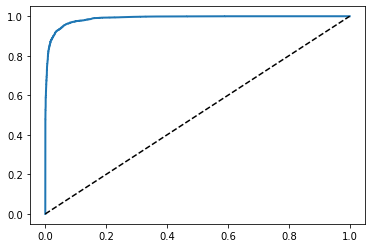

ROC AUC:  0.9887882416418459


In [0]:
roc_auc(y_test, lgbc_scores)